<H2>課題2: 予測モデルの作成</H2>
<p>本課題では課題1と同じデータを用いてデータ分析の流れを確認します。</p>
<p>2章で学んだ内容を踏まえ、各セルに入っているコメントを実行するコードを記入してください。</p>

<H2>1. 必要なモジュールを読み込む</H2>

In [1]:
% matplotlib inline

from __future__ import print_function

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.style.use('ggplot')

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<H2>2. データの読み込み</H2>
<p> pandasにはread_csvという関数が用意されており、それを用いれば簡単にCSVファイルを読み込むことができます</p>
<p>データはdatasetフォルダ直下にある"kaggle_housing_price.csv"を使用します。</p>

In [2]:
# データ読み込み
dataset = pd.read_csv("dataset/kaggle_housing_price.csv")

In [3]:
# データを最初の5行だけ表示
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h2>3. データの前処理</h2>

In [4]:
# 今回の解析では下記の列を使用することとします
target_col = 'SalePrice'
feature_cols = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'GarageCars']

In [5]:
# target_colとfeature_colsをarrayにして、それぞれをY、Xとする
Y = np.array(dataset[target_col])
X = np.array(dataset[feature_cols])

In [6]:
# DataをTrain　: Test = 7　:　3に分ける
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3 ,random_state = 0)
X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train, Y_train, test_size = 0.3 ,random_state = 0)

<H2>4. アルゴリズムの選択 </H2>
<p>回帰分析、決定木、ランダムフォレストを比較します</p>

In [7]:
# 回帰分析を実施しMSEを算出
lm = LinearRegression()
lm.fit(X_train1, Y_train1)
Y_pred = lm.predict(X_train2)
lm_mse = mean_squared_error(Y_train2, Y_pred)
print("LinerRegression MSE : {:,}".format(lm_mse))

LinerRegression MSE : 1,535,297,047.699687


In [8]:
#決定木を実行し、MSEを算出
dt = DecisionTreeRegressor()
dt.fit(X_train1, Y_train1)
Y_pred = dt.predict(X_train2)
dt_mse = mean_squared_error(Y_train2, Y_pred)
print("DecisionTree MSE : {:,}".format(dt_mse))

DecisionTree MSE : 1,733,442,160.7166123


In [9]:
# ランダムフォレストを実行し、MSEを算出
rf  =  RandomForestRegressor(random_state = 0)
rf.fit(X_train1, Y_train1)
Y_pred = rf.predict(X_train2)
rf_mse = mean_squared_error(Y_train2, Y_pred)
print("RandomForest MES : {:,}".format(rf_mse))

RandomForest MES : 1,044,616,903.7710096


<H2>5. 変数の選択</H2>

In [10]:
# 変数増加法を実行する関数
def get_gfs_feature_indices(X, y, features, clf):
    X_train_, X_test_, y_train_, y_test_ = \
        train_test_split(X, y, test_size=0.3, random_state=1234)
    feature_indices = {feature: idx for idx, feature in enumerate(features)}
    features = set(features)
    last_mse = np.inf
    chosen_features = set()
    while len(chosen_features) < len(features):
        mse_features = []
        for feature in (features - chosen_features):
            candidates = chosen_features.union(set([feature]))
            indices = [feature_indices[feature] for feature in candidates]
            clf.fit(X_train_[:, indices], y_train_)
            y_pred = clf.predict(X_test_[:, indices])
            mse = mean_squared_error(y_test_, y_pred)
            mse_features += [(mse, feature)]
        mse, feature = min(mse_features)
        if mse >= last_mse:
            break
        last_mse = mse
        print('Newly Added Feature: {},\tMSE Score: {:,}'.format(feature, mse))
        chosen_features.add(feature)
    return [feature_indices[feature] for feature in chosen_features]

In [11]:
# 上記関数を使用して変数増加法を実行し、MSEを算出
selected_feature_index = get_gfs_feature_indices(X = X_train, y = Y_train,
                                                 features = feature_cols, 
                                                 clf = RandomForestRegressor(random_state = 0))

Newly Added Feature: OverallQual,	MSE Score: 2,308,979,414.216167
Newly Added Feature: BedroomAbvGr,	MSE Score: 2,009,333,000.767369
Newly Added Feature: BsmtFullBath,	MSE Score: 1,844,560,094.189146
Newly Added Feature: GarageCars,	MSE Score: 1,773,529,417.048288
Newly Added Feature: 1stFlrSF,	MSE Score: 1,648,073,337.2323706
Newly Added Feature: 2ndFlrSF,	MSE Score: 1,419,755,500.7695956
Newly Added Feature: YearBuilt,	MSE Score: 1,225,030,566.7371373
Newly Added Feature: BsmtFinSF1,	MSE Score: 1,189,217,751.2177055
Newly Added Feature: HalfBath,	MSE Score: 1,071,692,030.9368768
Newly Added Feature: OverallCond,	MSE Score: 1,058,250,719.9011365
Newly Added Feature: KitchenAbvGr,	MSE Score: 1,039,054,763.7339957
Newly Added Feature: BsmtFinSF2,	MSE Score: 999,634,736.3669963


<H2>6. ハイパーパラメータのチューニング</H2>

In [12]:
# 木の数：[10, 50, 100], 木の深さ:[5, 10, 50]でパラメータをチューニング
rf  =  RandomForestRegressor(random_state = 0)
params = {"n_estimators" : [10, 50, 100], "max_depth" :  [5, 10, 50]}
gscv = GridSearchCV(rf, param_grid = params, verbose = 1, cv = 3, scoring = "neg_mean_squared_error")
gscv.fit(X_train1[:, selected_feature_index], Y_train1)
gscv.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.5s finished


{'max_depth': 50, 'n_estimators': 100}

In [13]:
# チューニング後のランダムフォレストで再びMSEを算出し、精度を確認
rf = RandomForestRegressor(n_estimators = 100, max_depth = 50, random_state = 0)
rf.fit(X_train1[:, selected_feature_index], Y_train1)
Y_pred = rf.predict(X_train2[:, selected_feature_index])
rf_mse = mean_squared_error(Y_train2, Y_pred)
print("RandomForest MSE : {:,}".format(rf_mse))

RandomForest MSE : 952,153,016.6033496


<H2>7. モデルの評価</H2>

In [14]:
# Test dataを用いてMSEを算出し、予測精度を確認
rf = RandomForestRegressor(n_estimators = 100, max_depth = 50, random_state = 0)
rf.fit(X_train[:, selected_feature_index], Y_train)
Y_pred_on_test =rf.predict(X_test[:, selected_feature_index])
rf_mse = mean_squared_error(Y_test, Y_pred_on_test)
print("RandomForest MSE : {:,}".format(rf_mse))

RandomForest MSE : 954,489,100.6424901


<H2>8. エラー分析</H2>

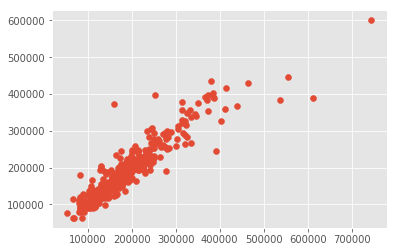

In [15]:
# 横軸：実際の成約価格、縦軸：予測した成約価格で散布図を作成し予測の誤差を確認
plt.scatter(Y_test, Y_pred_on_test)

Mean :  -0.025347191518359576
Std :  0.16549209041187637


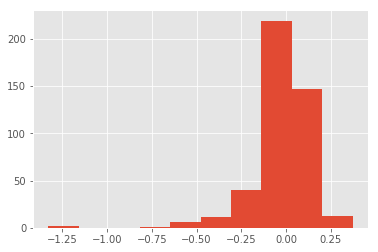

In [16]:
# 実際の成約価格と予測価格の誤差率をヒストグラムで表示
error_rate = (Y_test - Y_pred_on_test) / Y_test
plt.hist(error_rate)
print("Mean : ", np.mean(error_rate))
print("Std : ", np.std(error_rate))